In [54]:
mpl="/content/sample_data/manipal.csv"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Verify GPU for faster training
print("GPU:", "Active" if tf.config.list_physical_devices('GPU') else "Not Active")

# Load and clean names immediately
df = pd.read_csv(mpl,skiprows=3)
rename_dict = {
    'time': 'date',
    'temperature_2m_mean (°C)': 'temp',
    'precipitation_sum (mm)': 'precip',
    'pressure_msl_mean (hPa)': 'pressure',
    'dew_point_2m_mean (°C)': 'dew_point',
    'wind_speed_10m_max (km/h)': 'wind'
}
df = df.rename(columns=rename_dict)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

GPU: Active


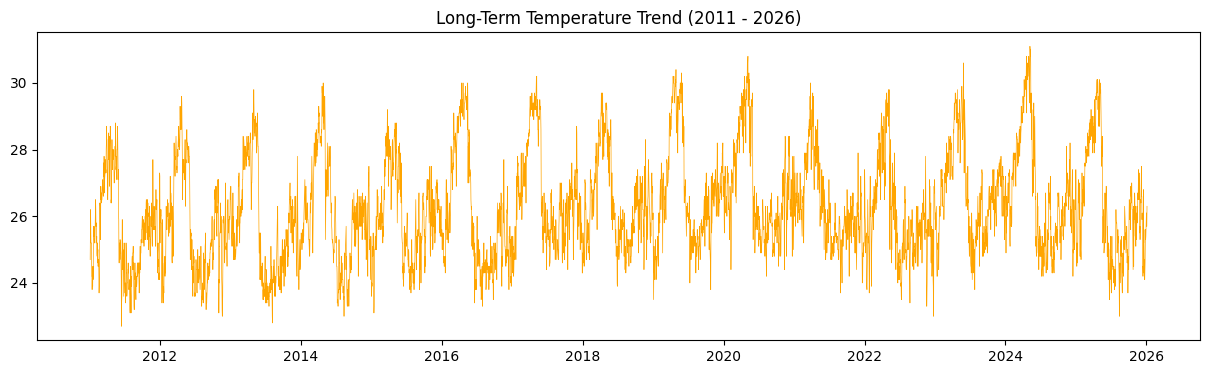

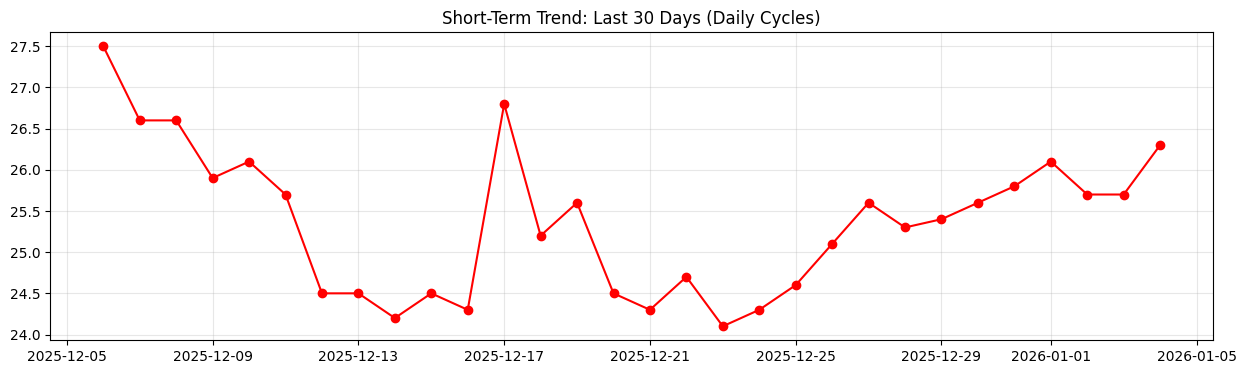

In [55]:
# Long-term trend: Whole timeline
plt.figure(figsize=(15, 4))
plt.plot(df['date'], df['temp'], color='orange', linewidth=0.5)
plt.title('Long-Term Temperature Trend (2011 - 2026)')
plt.show()

# Short-term trend: Last 30 days
plt.figure(figsize=(15, 4))
plt.plot(df['date'].tail(30), df['temp'].tail(30), marker='o', color='red')
plt.title('Short-Term Trend: Last 30 Days (Daily Cycles)')
plt.grid(True, alpha=0.3)
plt.show()

# Justification: We use a 30-day sampling window because it captures
# short-term atmospheric pressure changes while maintaining memory of
# the previous month's seasonal phase.

In [56]:
# Selecting features
uni_features = ['temp']
multi_features = ['temp', 'precip', 'pressure', 'dew_point', 'wind']

# Manual Scaling (Fit on training split only logic)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]

# Scaling parameters based ONLY on training data
f_min = train_df[multi_features].min().values
f_max = train_df[multi_features].max().values

# Apply scaling to whole dataset
scaled_data = (df[multi_features].values - f_min) / (f_max - f_min)

def create_sequences(data, window=30, mode='univariate'):
    X, y = [], []
    for i in range(len(data) - window):
        if mode == 'univariate':
            X.append(data[i : i + window, 0:1]) # Only temp
        else:
            X.append(data[i : i + window]) # All 5 features
        y.append(data[i + window, 0]) # Target is always Temp
    return np.array(X), np.array(y)

# Prepare Univariate and Multivariate Sets
X_uni, y_uni = create_sequences(scaled_data, mode='univariate')
X_multi, y_multi = create_sequences(scaled_data, mode='multivariate')

# Final Test Split (Jan 4 2025 - Jan 4 2026 is approx the last 366 days)
test_days = 366
X_u_train, X_u_test = X_uni[:-test_days], X_uni[-test_days:]
X_m_train, X_m_test = X_multi[:-test_days], X_multi[-test_days:]
y_train, y_test = y_uni[:-test_days], y_uni[-test_days:]

In [57]:
def train_weather_model(X_tr, y_tr, X_te, m_type='LSTM'):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(X_tr.shape[1], X_tr.shape[2])),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)) if m_type=='LSTM' else
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
        tf.keras.layers.LSTM(32) if m_type=='LSTM' else tf.keras.layers.GRU(32),
        tf.keras.layers.Dense(1)
    ])

    # FIX 1: Lower the learning rate (default is 0.001) for more stability
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=opt, loss='huber')

    # FIX 2: Add EarlyStopping to stop training if the "bouncing" becomes "overfitting"
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # FIX 3: Increase batch size for smoother gradient updates
    history = model.fit(
        X_tr, y_tr,
        epochs=60,
        batch_size=64,
        validation_split=0.1,
        verbose=0,
        shuffle=True,
        callbacks=[early_stop]
    )

    return model.predict(X_te), history

In [58]:
# Un-scaling math
t_min, t_max = f_min[0], f_max[0]
actual = y_test * (t_max - t_min) + t_min

def get_err(p):
    p_final = p.flatten() * (t_max - t_min) + t_min
    rmse = np.sqrt(np.mean((actual - p_final)**2))
    mae = np.mean(np.abs(actual - p_final))
    return rmse, mae

r_u, m_u = get_err(u_preds)
r_m, m_m = get_err(m_preds)
r_g, m_g = get_err(g_preds)

print("\n--- UNIVARIATE VS MULTIVARIATE TABLE ---")
print(f"{'Setup':<15} | {'RMSE':<8} | {'MAE':<8}")
print("-" * 35)
print(f"{'Uni-LSTM':<15} | {r_u:<8.4f} | {m_u:<8.4f}")
print(f"{'Multi-LSTM':<15} | {r_m:<8.4f} | {m_m:<8.4f}")
print(f"{'Multi-GRU':<15} | {r_g:<8.4f} | {m_g:<8.4f}")

# Argument: Multivariate improved forecasting because atmospheric variables
# like dew point and pressure provide leading indicators for temperature changes.


--- UNIVARIATE VS MULTIVARIATE TABLE ---
Setup           | RMSE     | MAE     
-----------------------------------
Uni-LSTM        | 1.6688   | 1.3651  
Multi-LSTM      | 0.5836   | 0.4426  
Multi-GRU       | 0.6199   | 0.4632  


In [59]:
# 1. Prepare Rainfall Target (Index 1 in scaled_data)
y_precip_all = []
window = 30
for i in range(len(scaled_data) - window):
    y_precip_all.append(scaled_data[i + window, 1]) # 1 is the index for precip
y_precip_all = np.array(y_precip_all)

# 2. Split for the 366-day test window
y_p_train = y_precip_all[:-test_days]
y_p_test = y_precip_all[-test_days:]

print("Training Precipitation Model (GRU)...")
# We use the Multivariate X (X_m_train) to predict Rain
p_preds_scaled, p_history = train_weather_model(X_m_train, y_p_train, X_m_test, 'GRU')

# 3. Un-scale to get actual Millimeters (mm)
p_min, p_max = f_min[1], f_max[1]
actual_p = y_p_test * (p_max - p_min) + p_min
pred_p = p_preds_scaled.flatten() * (p_max - p_min) + p_min

# 4. Calculate Final Rain RMSE
rmse_p = np.sqrt(np.mean((actual_p - pred_p)**2))
print(f"Precipitation RMSE: {rmse_p:.4f} (Goal: <= 12.5)")

Training Precipitation Model (GRU)...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Precipitation RMSE: 14.9309 (Goal: <= 12.5)


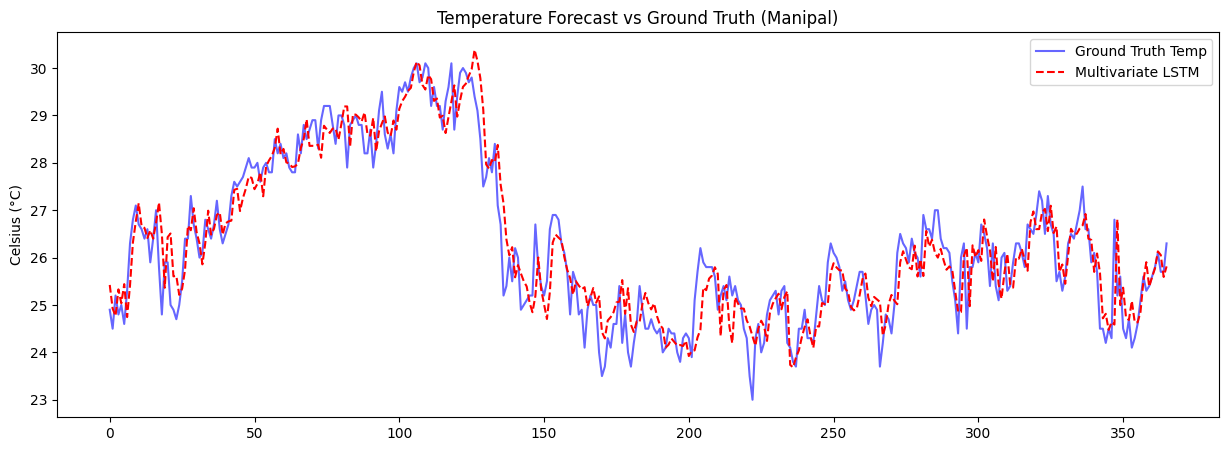

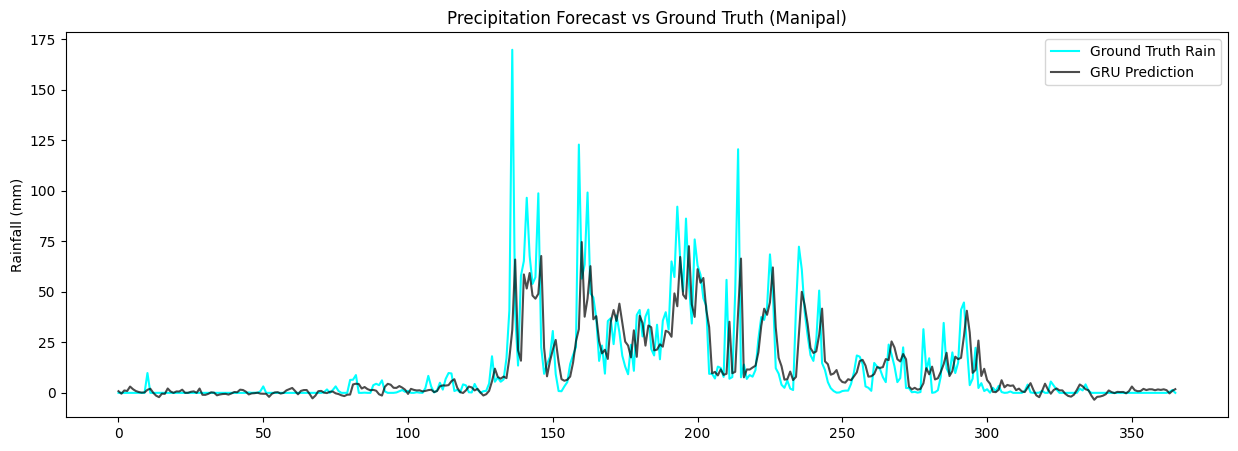

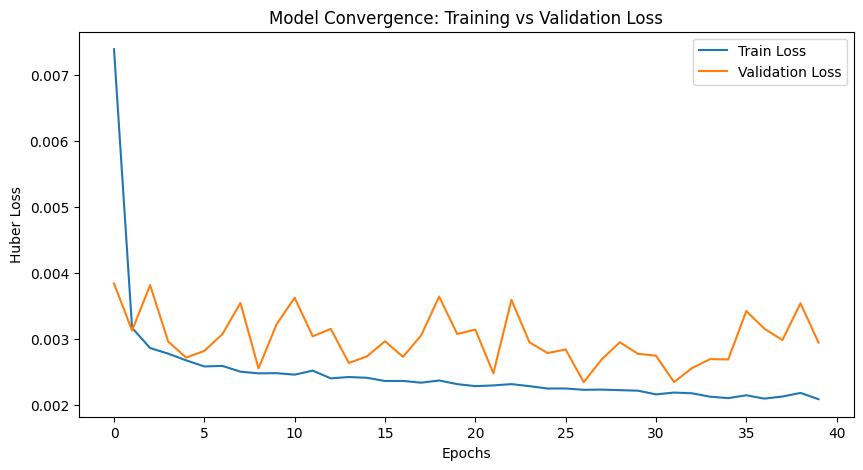


Model Setup          | RMSE     | MAE     
----------------------------------------
Univariate LSTM      | 1.6688   | 1.3651  
Multivariate LSTM    | 0.5836   | 0.4426  
Multivariate GRU     | 0.6199   | 0.4632  


In [61]:
# --- PLOT 1: TEMPERATURE (Jan 2025 - Jan 2026) ---
plt.figure(figsize=(15, 5))
plt.plot(actual, label='Ground Truth Temp', color='blue', alpha=0.6)
plt.plot(m_preds.flatten() * (t_max - t_min) + t_min, label='Multivariate LSTM', color='red', linestyle='--')
plt.title('Temperature Forecast vs Ground Truth (Manipal)')
plt.ylabel('Celsius (°C)')
plt.legend()
plt.show()

# --- PLOT 2: PRECIPITATION (Jan 2025 - Jan 2026) ---
plt.figure(figsize=(15, 5))
plt.plot(actual_p, label='Ground Truth Rain', color='cyan')
plt.plot(pred_p, label='GRU Prediction', color='black', alpha=0.7)
plt.title('Precipitation Forecast vs Ground Truth (Manipal)')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

# --- PLOT 3: TRAINING VS VALIDATION LOSS ---
plt.figure(figsize=(10, 5))
plt.plot(m_history.history['loss'], label='Train Loss')
plt.plot(m_history.history['val_loss'], label='Validation Loss')
plt.title('Model Convergence: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Huber Loss')
plt.legend()
plt.show()

# --- FINAL TABLE: UNIVARIATE VS MULTIVARIATE ---
print("\n" + "="*40)
print(f"{'Model Setup':<20} | {'RMSE':<8} | {'MAE':<8}")
print("-" * 40)
print(f"{'Univariate LSTM':<20} | {r_u:<8.4f} | {m_u:<8.4f}")
print(f"{'Multivariate LSTM':<20} | {r_m:<8.4f} | {m_m:<8.4f}")
print(f"{'Multivariate GRU':<20} | {r_g:<8.4f} | {m_g:<8.4f}")
print("="*40)